In [1]:
try: 
    import cv2
    import torch
    import torchvision
    import sklearn.svm
    import mediapipe as mp
except:
    %pip install opencv-python-headless==4.9.0.80
    %pip install torch
    %pip install torchvision
    %pip install torchsummary 
    %pip install sklearn
    %pip install mediapipe


import cv2
import pickle
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import time

print('import successful')

2024-07-02 07:52:06.249618: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 07:52:06.312057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 07:52:06.360543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 07:52:06.360583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 07:52:06.401699: I tensorflow/core/platform/cpu_feature_gua

import successful


In [9]:
# Data paths
EMOREACT = Path('EmoReact')
FER = Path('FER-2013')
KDEF = Path('KDEF-AKDEF')
NIMH = Path('NIMH-CHEFS')

# General paths
BASE_PATH = Path('/home/jovyan/work/data/out')
MODEL_PATH = Path('/home/jovyan/work/models')

# Set dataset here
DATA = KDEF

# Dataset-specific paths
CURRENT_PATH = BASE_PATH / DATA
LABELS = [f.name for f in CURRENT_PATH.iterdir() if f.is_dir()]
IMAGE_PATHS = list(CURRENT_PATH.rglob('*.jpg'))

# Constants for splitting dataset
TRAIN = 'train'
TEST = 'test'
VAL = 'val'

# Feature extraction method
FEATURE = 'pixel'

# Parameters for Histogram of Oriented Gradients (HOG) feature extraction
orientations = 7
pixels_per_cell = 8
cells_per_block = 4

hog_params = { 
    'orientations': orientations,
    'pixels_per_cell': pixels_per_cell,
    'cells_per_block': cells_per_block
}
len(IMAGE_PATHS)

4893

### Dataset class

#### Reduce Dataset size

In [3]:
path = BASE_PATH / DATA / VAL / Path('Curiosity')
imgs = list(path.rglob('*.jpg'))
print(len(imgs))

random.shuffle(imgs)

sampled_imgs = imgs[:38]
files_to_delete = set(imgs) - set(sampled_imgs)

for file in files_to_delete:
    file.unlink()

print('finished')

0
finished


In [10]:
class Dataset(Dataset):
    def __init__(self, data_path, img_size=64, transform=None, model_path_mesh='/home/jovyan/work/models/face_landmarker.task', **kwargs):
        self.data_path = Path(data_path)
        self.img_size = img_size
        self.transform = transform

        self.classes = self._get_classes()
        self.image_paths = self._get_image_paths()

        self.hog_args = kwargs
        self.labels = []
        self.data = []
        self.df = pd.DataFrame()

        # mediapipe
        self.model_path_mesh = model_path_mesh
        self.base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
        self.options_mesh = vision.FaceLandmarkerOptions(base_options=self.base_options_mesh, output_face_blendshapes=True, 
                                                         output_facial_transformation_matrixes=True, num_faces=1)
        self.detector_mesh = vision.FaceLandmarker.create_from_options(self.options_mesh)

    
    def __len__(self):
        return len(self.image_paths)
    

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        img_path = self.image_paths[idx]

        if self.transform:
            img = self.transform(img)

        label = Path(img_path).parent.name
        return img, label

    
    def _get_classes(self):
        return [f.name for f in (self.data_path / TRAIN).iterdir() if f.is_dir()]
    

    def _get_image_paths(self):
        paths = list(self.data_path.rglob('*.jpg'))
        random.shuffle( paths )
        return paths
    

    def show_samples(self):
        fig = plt.figure(figsize=(20,20))

        for i in range(10):
            ax = fig.add_subplot(1, 10, i + 1)
            _, label = self.__getitem__(i)
            img_cv2 = self.get_cv2_img(i)

            ax.imshow(img_cv2, cmap='gray')
            ax.set_title(label)
            ax.axis('off')
        plt.show()


    def show_image(self, idx):
        img_cv2 = self.get_cv2_img(idx)
        plt.imshow(img_cv2, cmap='gray')
        plt.show()


    def show_distribution(self, save_plot=True):
        labels_count = Counter([self.__getitem__(i)[1] for i in tqdm(range(len(self.image_paths)))])
        sorted_counts = sorted(labels_count.items())
        labels, counts = zip(*sorted_counts)

        plt.figure(figsize=(10, 3))
        bars = plt.bar(labels, counts, color='skyblue')
        plt.xlabel(f'{DATA}')
        plt.ylabel('Count')
        plt.title('Counts per Emotion Category')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, count,
                    ha='center', va='bottom', color='black', fontsize=8) 
        
        if save_plot:
            figure_path = Path('/home/jovyan/work') / Path('distributions') 
            if not figure_path.exists():
                figure_path.mkdir(parents=True, exist_ok=True)
            plt.savefig(str(figure_path / self.data_path.name))

        plt.tight_layout()
        plt.show()
        

    def get_cv2_img(self, idx):
        img_path = self.image_paths[idx]
        img_cv2 = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2GRAY)
        img_cv2 = cv2.resize(img_cv2, dsize=(self.img_size, self.img_size))
        return img_cv2

    
    def extract_features(self, feature):
        print(f"[INFO] Extracting {feature} vectors ...")

        labels = []
        data = []

        for idx in tqdm(range(len(self))):
            
            img, label = self[idx]
            img_cv2 = self.get_cv2_img(idx)

            if feature == 'landmarks':

                rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
                detection_result = self.detector_mesh.detect(rgb_frame)

                if detection_result.face_landmarks:
                    array = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
                    labels.append(label)
                    data.append(array)

            elif feature == 'pixels':
                        
                labels.append(label)
                img_array = np.array(img).flatten()
                data.append(img_array)

            elif feature == 'hog':
                
                orientations = self.hog_args['hog_params'].get('orientations', None)
                pixels_per_cell = self.hog_args['hog_params'].get('pixels_per_cell', None)
                cells_per_block = self.hog_args['hog_params'].get('cells_per_block', None)

                if orientations is None or pixels_per_cell is None or cells_per_block is None:
                    raise ValueError("orientations, pixels_per_cell and cells_per_block are required for hog feature extraction")

                fd1 = hog(
                    img_cv2, orientations=orientations, 
                    pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                    cells_per_block=(cells_per_block, cells_per_block),
                    block_norm='L2-Hys',
                    transform_sqrt=False, 
                    feature_vector=True
                    )

                labels.append(label)
                data.append(fd1)

            elif feature == 'blendshapes':
                
                rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
                detection_result = self.detector_mesh.detect(rgb_frame)

                if detection_result.face_blendshapes:
                    array = np.array([[bs.index, bs.score] for bs in detection_result.face_blendshapes[0]]).flatten()
                    labels.append(label)
                    data.append(array)
            
            else:
                raise ValueError(f"[Value Error] Unsupported feature type: {feature}! Should be one of: [blendshapes, pixel, landmark, hog]")
        
        data = np.array(data)
        labels = np.array(labels)

        return data, labels


    def to_df(self, to_csv=False):
        df = pd.DataFrame()
        df[FEATURE] = [row for row in self.data.reshape(len(self.dataset), -1)]
        df['emotion'] = [value.item() for value in self.labels.reshape(-1, 1)]
        if to_csv:
            df.to_csv('features.csv')
        return df

In [11]:
feature_extraction_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),

    ])

dataset = Dataset(data_path=CURRENT_PATH, img_size=128, transform=feature_extraction_transform, hog_params=hog_params)

I0000 00:00:1719906932.006845   60978 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1719906932.008123   60978 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1719906932.023665   61594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719906932.052951   61594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


### SVM Class

In [12]:
class SVMClassifier:
    def __init__(self, data, labels, feature, n_splits_values = [10], **kwargs):   
        self.data = data
        self.labels = labels
        self.feature = feature
        self.n_split_values = n_splits_values
        self.best_estimator = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

    def train(self):
        since = time.time()
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.data, self.labels, test_size=0.2, shuffle=True, stratify=self.labels, random_state=42)
        
        print("init")
        classifier = SVC()
        
        # Fit the classifier on the training data
        classifier.fit(self.x_train, self.y_train)
        self.best_estimator = classifier

        model_path = str(MODEL_PATH / DATA)

        if not Path(model_path).exists():
            Path(model_path).mkdir(parents=True, exist_ok=True)

        pickle.dump(self.best_estimator, open(model_path + f'/{self.feature}_model.p', 'wb'))

        elapsed_time = time.time() - since
        print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    def print_score(self, train=True):
        if train:
            dataset_type = "Train"
            data, labels = self.x_train, self.y_train
        else:
            dataset_type = "Test"
            data, labels = self.x_test, self.y_test

        y_prediction = self.best_estimator.predict(data)
        clf_report = classification_report(labels, y_prediction)
        accuracy = accuracy_score(labels, y_prediction) * 100
        confusion_mat = confusion_matrix(labels, y_prediction)

        print(f"{dataset_type} Result:\n{'=' * 50}")
        print(f"Accuracy Score: {accuracy:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n{confusion_mat}\n")


    def k_fold(self):
        print(f"[INFO] Evaluating mode: {self.feature}")

        for n_splits in self.n_splits_values:
            cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
            scores = cross_val_score(self.best_estimator, self.data, self.labels, scoring='accuracy', cv=cv, n_jobs=2)
            print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}") 

100%|██████████| 35881/35881 [10:39<00:00, 56.11it/s]


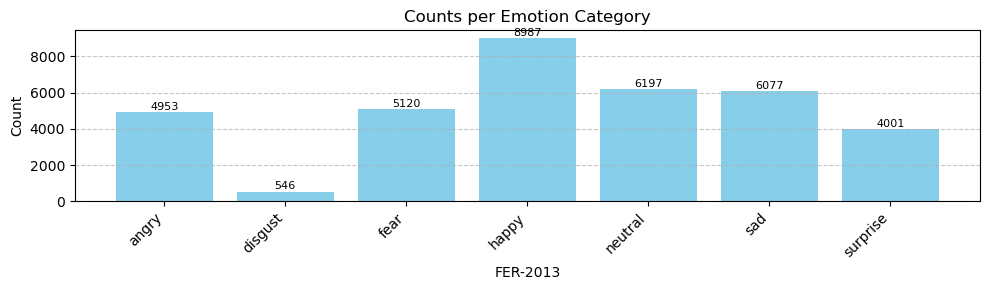

In [37]:
dataset.show_distribution()

In [13]:
#pixel_data, pixel_labels = dataset.extract_features(feature='pixels')

#landmark_data, landmark_labels = dataset.extract_features(feature='landmarks')

hog_data, hog_labels = dataset.extract_features(feature='hog')

#blendshapes_data, blendshapes_labels = dataset.extract_features(feature='blendshapes')

[INFO] Extracting hog vectors ...


100%|██████████| 4893/4893 [05:14<00:00, 15.53it/s]


In [ ]:
pixel_svm = SVMClassifier(data=pixel_data, labels=pixel_labels, feature='pixel')
pixel_svm.train()

In [ ]:
pixel_svm.print_score(train=True)
pixel_svm.print_score(train=False)

print('finished')

In [ ]:
landmarks_svm = SVMClassifier(data=landmark_data, labels=landmark_labels, feature='landmark')
landmarks_svm.train()

In [15]:
hog_svm = SVMClassifier(data=hog_data, labels=hog_labels, feature='hog')
hog_svm.train()

init
Training completed in 50m 28s


In [ ]:
hog_svm.print_score(train=True)
hog_svm.print_score(train=False)


In [ ]:
blendshapes_svm = SVMClassifier(data=blendshapes_data, labels=blendshapes_labels, feature='blendshapes')
blendshapes_svm.train()

In [ ]:
svm_classifier.k_fold()

In [ ]:
classifier = SVC(C=100)

# Fit the classifier on the training data
classifier.fit(x_train, y_train)

In [ ]:
print('hello')